In [37]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import glob
from scipy.special import exp1,factorial
from scipy.stats import binom,nbinom

### Section 1: compute values for y axis correction

Goal: compute length (in kb) of exome on chrom 1 with potential for a LoF/Missense/Synonymous site

Data sources: 
- UKB BED file for WES targets (https://biobank.ndph.ox.ac.uk/ukb/refer.cgi?id=3803)
- potential LoF sites from Zeng et al. 2023, file `gnomad_lofs_with_misannotation_probabilitites.tsv.gz` (https://zenodo.org/records/10403680)

For **synonymous** sites: this is 1/3 of the total length of exome sequence 

For **missense** sites: this is 2/3 of the total length of exome sequence

We also need to divide each SFS entry by the _proportion of snps kept_ in the downsampling procedure. E.g., for synonymous variants, chrom 1 contained 247,378 SNPs, but we downsampled to 32,320, so we will divied by 32320/247378=0.1302. Same for missense (for LoF we kept all variants, so this proportion is just 1). 

For **LoF** sites: we will use the list of potential LoF sites from Zeng et al. to compute # potential LoFs in sequencing targets directly.

In [2]:
## First compute the proportions...
# proportion of sites kept
prop_kept_syn = 32320/247378
prop_kept_mis = 32320/505963
print(f"Prop. kept for syn: {prop_kept_syn}")
print(f"Prop. kept for mis: {prop_kept_mis}")

Prop. kept for syn: 0.130650259926105
Prop. kept for mis: 0.06387818872130967


In [3]:
## Now compute length of exome sequence. Starting with  UKB target regions on chromosome 1...
bed_file = "../empirical/subsampling_SIR_v20250127/metadata/xgen_plus_spikein.GRCh38.bed"
df_bed = pd.read_csv(bed_file, sep='\t', header=None, names=["chr", "start", "end"])
df_bed["length"] = df_bed["end"] - df_bed["start"]
df_bed

,chr,start,end,length
0,chr1,69090,70008,918
1,chr1,450739,451678,939
2,chr1,685715,686654,939
3,chr1,925941,926013,72
4,chr1,930154,930336,182
...,...,...,...,...
204824,chrY,57190939,57191085,146
204825,chrY,57191797,57191999,202
204826,chrY,57192602,57192708,106
204827,chrY,57194042,57194127,85


In [4]:
# sanity check - sum of lengths should be around 39 Mbp
df_bed['length'].sum()

38997831

In [5]:
# length of chromosome 1 regions only
df_chr1_bed=df_bed[df_bed['chr']=='chr1']
chr1_len = df_chr1_bed['length'].sum()
chr1_len

3924065

In [6]:
# length (in kb) of "synonymous" exome on chr1
len_syn = (1/3)*chr1_len/1000
len_syn # length factor for synonymous sites

1308.0216666666665

In [7]:
# length (in kb) of "missense" exome on chr1
len_mis = (2/3)*df_chr1_bed["length"].sum()/1000
len_mis # length factor for synonymous sites

2616.043333333333

In [8]:
## potential LoF sites - from Zeng et al. results
lofsites = pd.read_csv('../empirical/subsampling_SIR_v20250127/metadata/gnomad_lofs_with_misannotation_probabilities.tsv',delimiter='\t')

/var/folders/r0/wf2xsjdx3h366x3_hj3b7xdc0000gp/T/ipykernel_76669/1845316902.py:2: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  lofsites = pd.read_csv('../empirical/subsampling_SIR_v20250127/metadata/gnomad_lofs_with_misannotation_probabilities.tsv',delimiter='\t')


In [9]:
# filter to chrom1
lofsites_chr1 = lofsites[lofsites['chr']==1]
lofsites_chr1

,Unnamed: 0,ensg,locus,ref,alt,lof,csq,lof_flag,mean_proportion,context,...,median_coverage,symbol,chr,start,end,low_map_or_segdup,num_gt,consequence,p_misannotation,pos_hg38
908252,908252,ENSG00000107404,1:1271578,G,['A'],['HC'],['stop_gained'],[{'None'}],[0.950484],CCA,...,33.0,DVL1,1,1271577,1271578,False,250312.0,['stop_gained'],0.009288,1336198.0
908253,908253,ENSG00000107404,1:1271592,A,['T'],['HC'],['stop_gained'],[{'None'}],[0.950484],TTG,...,32.0,DVL1,1,1271591,1271592,False,250312.0,['stop_gained'],0.009494,1336212.0
908254,908254,ENSG00000107404,1:1271596,C,['A'],['HC'],['stop_gained'],[{'None'}],[0.950484],GGA,...,32.0,DVL1,1,1271595,1271596,False,250312.0,['stop_gained'],0.009434,1336216.0
908255,908255,ENSG00000107404,1:1271617,C,['A'],['HC'],['stop_gained'],[{'None'}],[0.950484],GGA,...,26.0,DVL1,1,1271616,1271617,False,250312.0,['stop_gained'],0.009434,1336237.0
908256,908256,ENSG00000107404,1:1271632,C,['A'],['HC'],['stop_gained'],[{'None'}],[0.950484],GGG,...,23.0,DVL1,1,1271631,1271632,False,250312.0,['stop_gained'],0.009419,1336252.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2981843,2981843,ENSG00000168679,1:110931913,G,"['C', 'T']","['HC', 'HC']","['stop_gained', 'stop_gained']","[{'PHYLOCSF_WEAK'}, {'PHYLOCSF_WEAK'}]","[0.693263, 0.693263]",ACA,...,97.0,SLC16A4,1,110931912,110931913,False,250312.0,"['stop_gained', 'stop_gained']",0.009496,110389291.0
2981844,2981844,ENSG00000168679,1:110931921,G,['A'],['HC'],['stop_gained'],[{'PHYLOCSF_WEAK'}],[0.693263],CCA,...,91.0,SLC16A4,1,110931920,110931921,False,250312.0,['stop_gained'],0.009488,110389299.0
2981845,2981845,ENSG00000168679,1:110931927,T,['A'],['HC'],['stop_gained'],[{'PHYLOCSF_WEAK'}],[0.693263],GAA,...,85.0,SLC16A4,1,110931926,110931927,False,250312.0,['stop_gained'],0.009522,110389305.0
2981846,2981846,ENSG00000168679,1:110931933,C,['A'],['HC'],['stop_gained'],[{'PHYLOCSF_WEAK'}],[0.693263],GGA,...,82.0,SLC16A4,1,110931932,110931933,False,250312.0,['stop_gained'],0.009512,110389311.0


In [10]:
## some functions to use to compute which region from bed file a particular variant sits in...
def in_region(row):
    return interval_idx.contains(row['pos_hg38']).any() # return True if position in at least one region

def find_region_index(row):
    mask = interval_idx.contains(row['pos_hg38'])  # Vectorized check
    matching_indices = df_chr1_bed.index[mask]  # Get matching indices
    return matching_indices[0] if not matching_indices.empty else None  # Return first match or None
    
df_chr1_bed['interval'] = pd.IntervalIndex.from_arrays(df_chr1_bed['start'], df_chr1_bed['end'], closed='both')
interval_idx = pd.IntervalIndex(df_chr1_bed['interval'])

/var/folders/r0/wf2xsjdx3h366x3_hj3b7xdc0000gp/T/ipykernel_76669/959839440.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chr1_bed['interval'] = pd.IntervalIndex.from_arrays(df_chr1_bed['start'], df_chr1_bed['end'], closed='both')


In [11]:
lofsites_chr1['in_region'] = lofsites_chr1.apply(in_region, axis=1)
lofsites_chr1['region_index'] = lofsites_chr1.apply(find_region_index, axis=1)

/var/folders/r0/wf2xsjdx3h366x3_hj3b7xdc0000gp/T/ipykernel_76669/3400125872.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lofsites_chr1['in_region'] = lofsites_chr1.apply(in_region, axis=1)
/var/folders/r0/wf2xsjdx3h366x3_hj3b7xdc0000gp/T/ipykernel_76669/3400125872.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lofsites_chr1['region_index'] = lofsites_chr1.apply(find_region_index, axis=1)


In [12]:
## Most snps are in one of the regions from bed file...
lofsites_chr1['in_region'].value_counts()

in_region
True     167616
False     31699
Name: count, dtype: int64

In [13]:
region_counts = lofsites_chr1['region_index'].value_counts().reindex(df_chr1_bed.index, fill_value=np.nan)

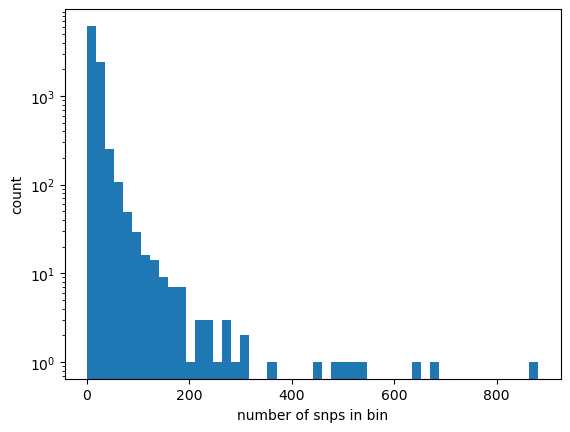

In [14]:
## Plot of number of snps per bin...
region_counts.hist(bins=50)
plt.yscale('log')
plt.grid(False)
plt.xlabel('number of snps in bin')
plt.ylabel('count')
plt.show()

In [15]:
## number of non-empty regions...
len(lofsites_chr1['region_index'].unique())

9137

In [16]:
## The length in kb of potential lof sequence is the # of sites in the bed regions/1000
len_lof = len(lofsites_chr1[lofsites_chr1['in_region']==True])/1000
len_lof

167.616

In [17]:
## In summary...
print(f'Length for synonymous: {len_syn}')
print(f'Length for missense: {len_mis}')
print(f'Length for lof: {len_lof}')

Length for synonymous: 1308.0216666666665
Length for missense: 2616.043333333333
Length for lof: 167.616


### Section 2: SFS plots with these y axis corrections

In [18]:
## plotting params
plt.rcParams['axes.labelsize'] = 8    
plt.rcParams['axes.titlesize'] = 9    
plt.rcParams['xtick.labelsize'] = 8   
plt.rcParams['ytick.labelsize'] = 8 
plt.rcParams['legend.fontsize'] = 8
plt.rcParams['font.family']='Arial'
# Define plot parameters and styles
colors = ['#440154',  # Dark Purple (Viridis)
          '#3b528b',  # Blue (Viridis)
          '#21918c',  # Teal (Viridis)
          '#5ec962',  # Green (Viridis)
          '#f03b20',  # Red (Warm)
          '#fd8d3c',  # Orange (Warm)
          '#fdae61',  # Light Orange (Warm)
          '#fee08b']  # Light Yellow (Warm)


synonymous
170.89337073897704
missense
167.10810974979066
lof
167.616


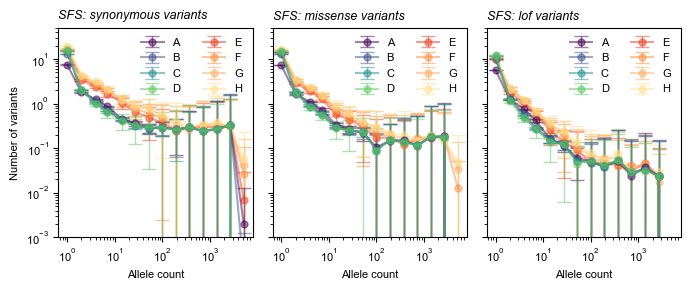

In [21]:
nbins = 15
sfs_unif = pd.read_csv(f'../empirical/subsampling_SIR_v20250127/results/sfs/chr1_lof_uniformgeo_nSIR10000_nSIRreps10.SIRsfs', sep=' ')
sfs_unif_grouped = sfs_unif.groupby('OBS_N')['COUNT_SITES'].agg(['mean', 'std'])
sfs_unif_avg = sfs_unif_grouped['mean']
log_bins = np.logspace(np.log10(1), np.log10(sfs_unif_avg.index.max()), num=nbins)  # Start from 1 instead of 10
log_bins = np.unique(np.round(log_bins))

vartypes = ['synonymous', 'missense', 'lof']
centers_geo = ['centerE16N4', 'centerE9N9', 'centerE6N4']
w_list_geo = ['50000', '100000', '150000']
labs_geo = ['A', 'B', 'C', 'D']

centers_pca = ['centerX19Y4']
w_list_pca = [0.0015, 0.0025, 0.005]
labs_pca = ['E', 'F', 'G', 'H']



# Create a 3-panel plot
fig, axes = plt.subplots(1, 3, figsize=(7.01, 3), sharex=True, sharey=True)

for k, vt in enumerate(vartypes):
    ax = axes[k]
    print(vt)
    if vt=='synonymous':
        scale_factor = len_syn*prop_kept_syn # also divide by prop kept
    elif vt=='missense':
        scale_factor = len_mis*prop_kept_mis # also divide by prop kept
    elif vt=='lof':
        scale_factor = len_lof
    print(scale_factor)
    
    # Process PCA data
    sfs_unif_pca = pd.read_csv(f'../empirical/subsampling_SIR_v20250127/results/sfs/chr1_{vt}_uniformpca_nSIR10000_nSIRreps10.SIRsfs', sep=' ')
    sfs_unif_pca_grouped = sfs_unif_pca.groupby('OBS_N')['COUNT_SITES'].agg(['mean', 'std'])
    sfs_unif_pca_avg = sfs_unif_pca_grouped['mean']/scale_factor
    sfs_unif_pca_std = sfs_unif_pca_grouped['std']/scale_factor
    
    sfs_unif_pca_binned, _ = np.histogram(sfs_unif_pca_avg.index, bins=log_bins, weights=sfs_unif_pca_avg.values)
    std_unif_pca_binned, _ = np.histogram(sfs_unif_pca_avg.index, bins=log_bins, weights=sfs_unif_pca_std.values)

    for j, w in enumerate(w_list_pca):
        all_sfs_avg = []
        all_sfs_std = []

        for center in centers_pca:
            sfs = pd.read_csv(f'../empirical/subsampling_SIR_v20250127/results/sfs/chr1_{vt}_{center}pca{w}_nSIR10000_nSIRreps10.SIRsfs', delimiter=' ')
            sfs_avg_grouped = sfs.groupby('OBS_N')['COUNT_SITES'].agg(['mean', 'std'])
            all_sfs_avg.append(sfs_avg_grouped['mean']/scale_factor)
            all_sfs_std.append(sfs_avg_grouped['std']/scale_factor)


        sfs_avg_final = pd.concat(all_sfs_avg, axis=1).values
        sfs_avg_forindex = pd.concat(all_sfs_avg, axis=1)
        sfs_std_final = pd.concat(all_sfs_std, axis=1).values
        sfs_forindex = sfs_avg_forindex.mean(axis=1)
        sfs_avg_binned, _ = np.histogram(sfs_forindex.index, 
                                          bins=log_bins,
                                          weights=sfs_avg_final.flatten())
        std_gaussian_binned, _ = np.histogram(sfs_forindex.index,
                                               bins=log_bins,
                                               weights=sfs_std_final.flatten())


        ax.errorbar(log_bins[:-1], sfs_avg_binned, yerr=std_gaussian_binned, label=labs_pca[j], 
                    linestyle='-', marker='o', capsize=5, markersize=5, elinewidth=1, 
                    alpha=0.5, color=colors[j+4])
    ax.errorbar(log_bins[:-1], sfs_unif_pca_binned, yerr=std_unif_pca_binned, linestyle='-', 
                label=labs_pca[3], marker='o', capsize=5, markersize=5, elinewidth=1, 
                alpha=0.5, color=colors[7])

    # Load and process uniform data for geo
    sfs_unif_geo = pd.read_csv(f'../empirical/subsampling_SIR_v20250127/results/sfs/chr1_{vt}_uniformgeo_nSIR10000_nSIRreps10.SIRsfs', sep=' ')
    sfs_unif_geo_grouped = sfs_unif_geo.groupby('OBS_N')['COUNT_SITES'].agg(['mean', 'std'])
    sfs_unif_geo_avg = sfs_unif_geo_grouped['mean']/scale_factor
    sfs_unif_geo_std = sfs_unif_geo_grouped['std']/scale_factor

    # Binning for uniform data (geo)
    sfs_unif_geo_binned, _ = np.histogram(sfs_unif_geo_avg.index, bins=log_bins, weights=sfs_unif_geo_avg.values)
    std_unif_geo_binned, _ = np.histogram(sfs_unif_geo_avg.index, bins=log_bins, weights=sfs_unif_geo_std.values)
    
    # Process and plot Gaussian data for geo
    for j, w in enumerate(w_list_geo):
        all_sfs_avg = []
        all_sfs_std = []

        for center in centers_geo:
            sfs = pd.read_csv(f'../empirical/subsampling_SIR_v20250127/results/sfs/chr1_{vt}_{center}geo{w}_nSIR10000_nSIRreps10.SIRsfs', delimiter=' ')
            sfs_avg_grouped = sfs.groupby('OBS_N')['COUNT_SITES'].agg(['mean', 'std'])
            all_sfs_avg.append(sfs_avg_grouped['mean']/scale_factor)
            all_sfs_std.append(sfs_avg_grouped['std']/scale_factor)
        
        combined_sfs_avg = pd.concat(all_sfs_avg, axis=1)
        combined_sfs_std = pd.concat(all_sfs_std, axis=1)
        sfs_avg_final = combined_sfs_avg.mean(axis=1)
        sfs_std_final = combined_sfs_std.std(axis=1)

        sfs_avg_binned, _ = np.histogram(sfs_avg_final.index, bins=log_bins, weights=sfs_avg_final.values)
        std_gaussian_binned, _ = np.histogram(sfs_avg_final.index, bins=log_bins, weights=sfs_std_final.values)
        
        ax.errorbar(log_bins[:-1], sfs_avg_binned, yerr=std_gaussian_binned, label=labs_geo[j], 
                    linestyle='-', marker='o', capsize=5, markersize=5, elinewidth=1, 
                    alpha=0.5, color=colors[j])

    # Plot uniform data for geo
    ax.errorbar(log_bins[:-1], sfs_unif_geo_binned, yerr=std_unif_geo_binned, 
            linestyle='-', label=labs_geo[3], marker='o', capsize=5, 
            markersize=5, elinewidth=1, alpha=0.5, color=colors[3])
    
    # Customize each subplot
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylim(1e-3, 5e1)
    ax.set_title(f'SFS: {vt} variants', loc='left', fontstyle='italic')
    ax.set_xlabel("Allele count")
    if k == 0:
        ax.set_ylabel("Number of variants")
    # ax.legend(loc='upper right', ncol=2, frameon=False)
    handles, labels = ax.get_legend_handles_labels()
    order = [4,5,6,7,0,1,2,3]  # Define the desired order (e.g., reorder to ['Bird', 'Dog', 'Cat'])
    ax.legend([handles[i] for i in order], [labels[i] for i in order],loc='upper right',ncol=2,frameon=False)

plt.tight_layout()
plt.savefig(f'sfs_syn_miss_lof_v20250217.pdf')
plt.show()


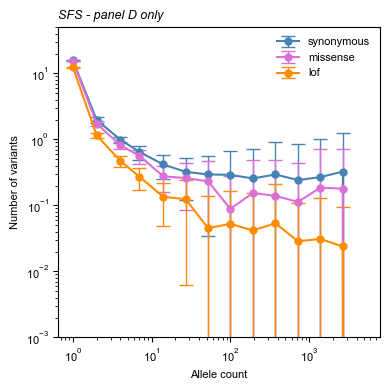

In [24]:
# Create a 1-panel plot for all variant types on the same axis
fig, ax = plt.subplots(figsize=(4, 4))  # Use only 1 axis
colors_2 = ['steelblue','orchid','darkorange']
for k, vt in enumerate(vartypes):
    
    if vt == 'synonymous':
        scale_factor = len_syn * prop_kept_syn
    elif vt == 'missense':
        scale_factor = len_mis * prop_kept_mis
    elif vt == 'lof':
        scale_factor = len_lof  
    
    # Process PCA data for line D only
    sfs_unif_pca = pd.read_csv(f'../empirical/subsampling_SIR_v20250127/results/sfs/chr1_{vt}_uniformpca_nSIR10000_nSIRreps10.SIRsfs', sep=' ')
    sfs_unif_pca_grouped = sfs_unif_pca.groupby('OBS_N')['COUNT_SITES'].agg(['mean', 'std'])
    sfs_unif_pca_avg = sfs_unif_pca_grouped['mean'] / scale_factor
    sfs_unif_pca_std = sfs_unif_pca_grouped['std'] / scale_factor

    # Create log bins
    log_bins = np.logspace(np.log10(1), np.log10(sfs_unif_pca_avg.index.max()), num=nbins)
    log_bins = np.unique(np.round(log_bins))

    # Process Geo data for line D only
    sfs_unif_geo = pd.read_csv(f'../empirical/subsampling_SIR_v20250127/results/sfs/chr1_{vt}_uniformgeo_nSIR10000_nSIRreps10.SIRsfs', sep=' ')
    sfs_unif_geo_grouped = sfs_unif_geo.groupby('OBS_N')['COUNT_SITES'].agg(['mean', 'std'])
    sfs_unif_geo_avg = sfs_unif_geo_grouped['mean'] / scale_factor
    sfs_unif_geo_std = sfs_unif_geo_grouped['std'] / scale_factor

    # Binning for Geo data (line D)
    sfs_unif_geo_binned, _ = np.histogram(sfs_unif_geo_avg.index, bins=log_bins, weights=sfs_unif_geo_avg.values)
    std_unif_geo_binned, _ = np.histogram(sfs_unif_geo_avg.index, bins=log_bins, weights=sfs_unif_geo_std.values)
    
    ax.errorbar(log_bins[:-1], sfs_unif_geo_binned, yerr=std_unif_geo_binned, linestyle='-', 
                label=f'{vt}', marker='o', capsize=5, markersize=5, elinewidth=1, 
                alpha=1, color=colors_2[k])  # Use a different color for geo data

# Customize the plot
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1e-3, 5e1)
ax.set_title(f'SFS - panel D only', loc='left', fontstyle='italic')
ax.set_xlabel("Allele count")
ax.set_ylabel("Number of variants")

# Show the legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='upper right', ncol=1, frameon=False)

plt.tight_layout()
plt.savefig('sfs_panelDonly_v20250217.pdf')
plt.show()


### Section 3: Comparison with theory

In [29]:
### Step 1 - save SFS mean data from panel D plot above to arrays for easy plotting/comparison
# No binning
sfs_list = []
for k, vt in enumerate(vartypes):
    
    if vt == 'synonymous':
        scale_factor = len_syn * prop_kept_syn
    elif vt == 'missense':
        scale_factor = len_mis * prop_kept_mis
    elif vt == 'lof':
        scale_factor = len_lof  
    
    # Process PCA data for line D only
    sfs_unif_pca = pd.read_csv(f'../empirical/subsampling_SIR_v20250127/results/sfs/chr1_{vt}_uniformpca_nSIR10000_nSIRreps10.SIRsfs', sep=' ')
    sfs_unif_pca_grouped = sfs_unif_pca.groupby('OBS_N')['COUNT_SITES'].agg(['mean', 'std'])
    sfs_unif_pca_avg = sfs_unif_pca_grouped['mean'] / scale_factor
    sfs_unif_pca_std = sfs_unif_pca_grouped['std'] / scale_factor
    sfs_list.append(sfs_unif_pca_avg)


In [30]:
vartypes

['synonymous', 'missense', 'lof']

In [176]:
# sfs_list

In [33]:
### Functions for theory

def get_lc(sigma,s):
    return np.sqrt(sigma**2/s)

def get_lambda_theory(w,sigma,s):
    lc = get_lc(sigma,s)
    term = (w / lc) ** 2
    if term <= 800:
        prod_term = np.exp(term) * exp1(term)
    else:
        prod_term = sum((factorial(k) / (-term)**k for k in range(7))) / term
    return (4*np.pi)/prod_term

def get_EP_theory(mu, s):
    return mu / s

def get_EPsquared_theory(mu, s, rho, sigma, w):
    lcs = get_lc(sigma, s)**2
    term = (w / np.sqrt(lcs)) ** 2
    if term <= 800:
        prod_term = np.exp(term) * exp1(term)
    else:
        prod_term = sum((factorial(k) / (-term)**k for k in range(7))) / term
    return (mu / (s ** 2 * rho * 4 * np.pi * lcs)) * prod_term + mu ** 2 / s ** 2

def get_sfs_theory(x,n,mu,s,rho,sigma,w):
    mean = get_EP_theory(mu,s)
    var = get_EPsquared_theory(mu,s,rho,sigma,w) - mean**2
    alpha = mean**2/var
    beta = mean/var
    return nbinom.pmf(x,alpha,beta/(beta+n))

def get_sfs_theory_unif(x,n,mu,s,N):
    mean = mu/s
    var = mu/(s*s*N)
    alpha = mean**2/var
    beta = mean/var
    return nbinom.pmf(x,alpha,beta/(beta+n))

In [209]:
### Step 2 - for each variant class try fitting combinations of params and report MSPE (mean square percentage error)

# MSPE will compute relative (percentage) error per SFS entry - to not bias towards singletons, other low frequency bins

## ranges 
sigma_list = [1, 5, 10]
rho_list = [1, 5, 10]
s_list = [1e-4, 1e-3, 1e-2]
w_list = [50,100,200]
mu_list = [2.5e-8]

# Given parameters
n = 10000
max_x = 10 # fit on first ten values

### synonymous variants

mspe_results = []  # store params and mspe

for sigma in sigma_list:
    for rho in rho_list:
        for s in s_list:
            for w in w_list:
                for mu in mu_list:
                    # theory
                    nb_dist = np.array([get_sfs_theory(y, n, mu, s, rho, sigma, w) * 1000 for y in np.arange(0, max_x)])
                    obs_dist = np.array(sfs_list[0][:max_x])  # 0 = synonymous
                    # mean square percentage error
                    mspe = np.mean(((nb_dist - obs_dist) / (obs_dist)) ** 2)
                    mspe_results.append((sigma, rho, s, w, mu, mspe, nb_dist))

# rank results
mspe_results.sort(key=lambda x: x[5])  # sorting by MSPE

# Print ranking
print(f"Ranking of parameter combinations by best fit (lowest MSPE), {vartypes[0]} variants:")
for rank, (sigma, rho, s, w, mu, mspe, _) in enumerate(mspe_results, 1):
    if rank<=20:
        print(f"{rank}. sigma={sigma}, rho={rho}, s={s:.1e}, w={w}, mu={mu:.1e}, MSPE={mspe:.5f}")

Ranking of parameter combinations by best fit (lowest MSPE), synonymous variants:
1. sigma=1, rho=1, s=1.0e-04, w=100, mu=2.5e-08, MSPE=2.94345
2. sigma=1, rho=5, s=1.0e-03, w=50, mu=2.5e-08, MSPE=2.95842
3. sigma=5, rho=1, s=1.0e-03, w=50, mu=2.5e-08, MSPE=2.98458
4. sigma=1, rho=1, s=1.0e-03, w=100, mu=2.5e-08, MSPE=3.02127
5. sigma=1, rho=1, s=1.0e-04, w=50, mu=2.5e-08, MSPE=3.12048
6. sigma=5, rho=1, s=1.0e-03, w=100, mu=2.5e-08, MSPE=3.13648
7. sigma=5, rho=5, s=1.0e-02, w=50, mu=2.5e-08, MSPE=3.23488
8. sigma=10, rho=1, s=1.0e-02, w=100, mu=2.5e-08, MSPE=3.24171
9. sigma=1, rho=10, s=1.0e-02, w=50, mu=2.5e-08, MSPE=3.24366
10. sigma=1, rho=5, s=1.0e-02, w=50, mu=2.5e-08, MSPE=3.26819
11. sigma=5, rho=1, s=1.0e-02, w=100, mu=2.5e-08, MSPE=3.27829
12. sigma=10, rho=5, s=1.0e-02, w=50, mu=2.5e-08, MSPE=3.28865
13. sigma=1, rho=1, s=1.0e-02, w=200, mu=2.5e-08, MSPE=3.30098
14. sigma=5, rho=10, s=1.0e-02, w=50, mu=2.5e-08, MSPE=3.30885
15. sigma=1, rho=1, s=1.0e-02, w=100, mu=2.5e-08,

In [207]:
### missense variants

mspe_results = []  # store params and mspe

for sigma in sigma_list:
    for rho in rho_list:
        for s in s_list:
            for w in w_list:
                for mu in mu_list:
                    # theory
                    nb_dist = np.array([get_sfs_theory(y, n, mu, s, rho, sigma, w) * 1000 for y in np.arange(0, max_x)])
                    obs_dist = np.array(sfs_list[1][:max_x])  # 1 = missense
                    # mean square percentage error
                    mspe = np.mean(((nb_dist - obs_dist) / (obs_dist)) ** 2)
                    mspe_results.append((sigma, rho, s, w, mu, mspe, nb_dist))

# rank results
mspe_results.sort(key=lambda x: x[5])  # sorting by MSPE

# Print ranking
print(f"Ranking of parameter combinations by best fit (lowest MSPE), {vartypes[1]} variants:")
for rank, (sigma, rho, s, w, mu, mspe, _) in enumerate(mspe_results, 1):
    if rank<=20:
        print(f"{rank}. sigma={sigma}, rho={rho}, s={s:.1e}, w={w}, mu={mu:.1e}, MSPE={mspe:.5f}")

Ranking of parameter combinations by best fit (lowest MSPE), missense variants:
1. sigma=1, rho=1, s=1.0e-03, w=100, mu=2.5e-08, MSPE=2.55420
2. sigma=5, rho=1, s=1.0e-03, w=50, mu=2.5e-08, MSPE=2.56645
3. sigma=1, rho=1, s=1.0e-04, w=50, mu=2.5e-08, MSPE=2.59163
4. sigma=10, rho=1, s=1.0e-02, w=100, mu=2.5e-08, MSPE=2.69407
5. sigma=5, rho=5, s=1.0e-02, w=50, mu=2.5e-08, MSPE=2.69793
6. sigma=1, rho=5, s=1.0e-02, w=50, mu=2.5e-08, MSPE=2.71322
7. sigma=1, rho=5, s=1.0e-03, w=50, mu=2.5e-08, MSPE=2.71954
8. sigma=1, rho=10, s=1.0e-02, w=50, mu=2.5e-08, MSPE=2.72107
9. sigma=5, rho=1, s=1.0e-02, w=100, mu=2.5e-08, MSPE=2.72216
10. sigma=1, rho=1, s=1.0e-02, w=100, mu=2.5e-08, MSPE=2.75215
11. sigma=10, rho=5, s=1.0e-02, w=50, mu=2.5e-08, MSPE=2.79836
12. sigma=1, rho=1, s=1.0e-02, w=200, mu=2.5e-08, MSPE=2.81794
13. sigma=10, rho=1, s=1.0e-02, w=50, mu=2.5e-08, MSPE=2.81825
14. sigma=5, rho=10, s=1.0e-02, w=50, mu=2.5e-08, MSPE=2.83028
15. sigma=5, rho=1, s=1.0e-02, w=200, mu=2.5e-08, M

In [208]:
### lof variants

mspe_results = []  # store params and mspe

for sigma in sigma_list:
    for rho in rho_list:
        for s in s_list:
            for w in w_list:
                for mu in mu_list:
                    # theory
                    nb_dist = np.array([get_sfs_theory(y, n, mu, s, rho, sigma, w) * 1000 for y in np.arange(0, max_x)])
                    obs_dist = np.array(sfs_list[2][:max_x])  # 2 = lof
                    # mean square percentage error
                    mspe = np.mean(((nb_dist - obs_dist) / (obs_dist)) ** 2)
                    mspe_results.append((sigma, rho, s, w, mu, mspe, nb_dist))

# rank results
mspe_results.sort(key=lambda x: x[5])  # sorting by MSPE

# Print ranking
print(f"Ranking of parameter combinations by best fit (lowest MSPE), {vartypes[2]} variants:")
for rank, (sigma, rho, s, w, mu, mspe, _) in enumerate(mspe_results, 1):
    if rank<=20:
        print(f"{rank}. sigma={sigma}, rho={rho}, s={s:.1e}, w={w}, mu={mu:.1e}, MSPE={mspe:.5f}")

Ranking of parameter combinations by best fit (lowest MSPE), lof variants:
1. sigma=1, rho=5, s=1.0e-02, w=50, mu=2.5e-08, MSPE=2.24710
2. sigma=10, rho=1, s=1.0e-02, w=100, mu=2.5e-08, MSPE=2.24716
3. sigma=5, rho=1, s=1.0e-02, w=100, mu=2.5e-08, MSPE=2.24879
4. sigma=1, rho=1, s=1.0e-02, w=100, mu=2.5e-08, MSPE=2.25621
5. sigma=5, rho=5, s=1.0e-02, w=50, mu=2.5e-08, MSPE=2.26075
6. sigma=10, rho=1, s=1.0e-02, w=50, mu=2.5e-08, MSPE=2.28082
7. sigma=1, rho=10, s=1.0e-02, w=50, mu=2.5e-08, MSPE=2.29487
8. sigma=5, rho=1, s=1.0e-02, w=50, mu=2.5e-08, MSPE=2.38902
9. sigma=1, rho=1, s=1.0e-03, w=50, mu=2.5e-08, MSPE=2.39368
10. sigma=10, rho=5, s=1.0e-02, w=50, mu=2.5e-08, MSPE=2.41611
11. sigma=1, rho=1, s=1.0e-02, w=200, mu=2.5e-08, MSPE=2.44940
12. sigma=5, rho=10, s=1.0e-02, w=50, mu=2.5e-08, MSPE=2.47081
13. sigma=5, rho=1, s=1.0e-02, w=200, mu=2.5e-08, MSPE=2.47600
14. sigma=1, rho=1, s=1.0e-02, w=50, mu=2.5e-08, MSPE=2.53015
15. sigma=10, rho=1, s=1.0e-02, w=200, mu=2.5e-08, MSPE=

Observation here: the same set of sigma, rho, w, mu params fit well with each variant type such that s changes over variant class:

- synonymous: sigma=1, rho=1, s=1.0e-04, w=100, mu=2.5e-08, MSPE=2.94345 (rank 1)
- missense: sigma=1, rho=1, s=1.0e-03, w=100, mu=2.5e-08, MSPE=2.55420 (rank 1)
- lof: sigma=1, rho=1, s=1.0e-02, w=100, mu=2.5e-08, MSPE=2.25621 (rank 4, but very close mspe to rank 1)

Try plotting these values and comparing...

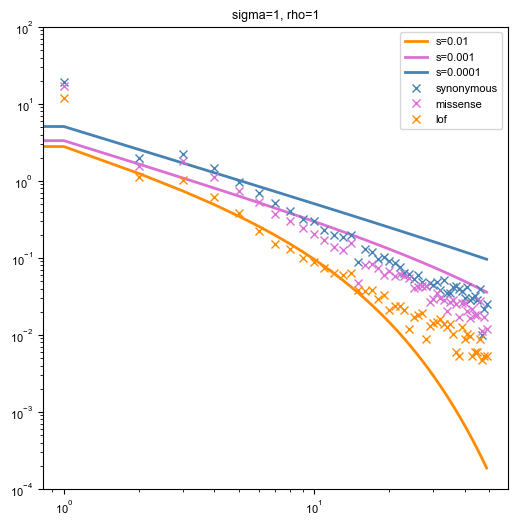

In [204]:
colors = ['darkorange', 'orchid', 'steelblue']

sigma = 1
mu = 2.5e-8
w = 100
n = 10000
rho = 1
max_x = 50
colors=['darkorange','orchid','steelblue']

fig,ax = plt.subplots(1,1,figsize=(6,6))
for i,s in enumerate([1e-2,1e-3,1e-4]):
    nb_dist = [get_sfs_theory(y, n, mu, s, rho, sigma, w)*1000 for y in np.arange(0, max_x)]
    ax.loglog(np.arange(0, max_x), nb_dist, marker=None, linestyle='-',linewidth=2, alpha=1, color=colors[i],label=f's={s}')
ax.loglog(np.arange(0,max_x),sfs_list[0][:max_x],marker='x',color='steelblue',linestyle='',label='synonymous')
ax.loglog(np.arange(0,max_x),sfs_list[1][:max_x],marker='x',color='orchid',linestyle='',label='missense')
ax.loglog(np.arange(0,max_x),sfs_list[2][:max_x],marker='x',color='darkorange',linestyle='',label='lof')
ax.legend()
ax.set_ylim(1e-4,1e2)
ax.set_title(f'sigma={sigma}, rho={rho}')
plt.show()